In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubmed-article-summarization-dataset/validation.csv
/kaggle/input/pubmed-article-summarization-dataset/train.csv
/kaggle/input/pubmed-article-summarization-dataset/test.csv


First few rows of the training dataset:


,article,abstract
0,a recent systematic analysis showed that in 20...,background : the present study was carried out...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who a...
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side effe...
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pes...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...


Missing values in each column:
article     2692
abstract       0
dtype: int64
Article word count statistics:
count    119924.000000
mean       3044.266644
std        2455.257727
min           0.000000
25%        1463.000000
50%        2572.000000
75%        3996.000000
max      109759.000000
Name: article_word_count, dtype: float64
Abstract word count statistics:
count    119924.000000
mean        202.235407
std          78.226149
min          42.000000
25%         142.000000
50%         208.000000
75%         262.000000
max         391.000000
Name: abstract_word_count, dtype: float64


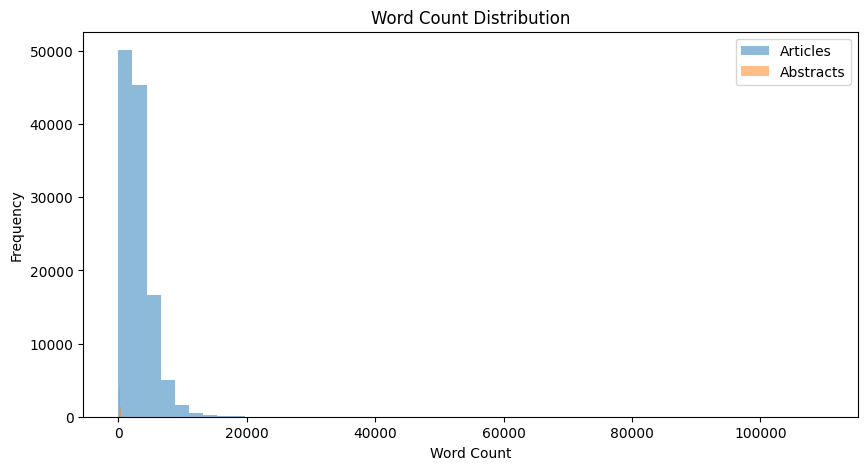

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('/kaggle/input/pubmed-article-summarization-dataset/train.csv')

# Display the first few rows to see the data structure
print("First few rows of the training dataset:")
display(train_df.head())

# Check for missing values in the dataset
print("Missing values in each column:")
print(train_df.isnull().sum())

# Compute word counts for articles and abstracts to understand text lengths
train_df["article_word_count"] = train_df["article"].apply(lambda x: len(str(x).split()))
train_df["abstract_word_count"] = train_df["abstract"].apply(lambda x: len(str(x).split()))

# Display descriptive statistics of the word counts
print("Article word count statistics:")
print(train_df["article_word_count"].describe())

print("Abstract word count statistics:")
print(train_df["abstract_word_count"].describe())

# Optional: Visualize the distribution of word counts for articles and abstracts
plt.figure(figsize=(10, 5))
plt.hist(train_df["article_word_count"], bins=50, alpha=0.5, label="Articles")
plt.hist(train_df["abstract_word_count"], bins=50, alpha=0.5, label="Abstracts")
plt.legend()
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [3]:
!pip install sumy


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.6 MB/s eta 0:00:00:00:010:01
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21692 sha256=3d0451c60d969cc0dd30a4f29ea4ddea5952f8180a1263d940b4d9edb68cd9f8
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=99e3d36654f1380273f1c57cd34ef1bf3645aad144ad3c87ca06e24522b3b90e
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


In [1]:
import os
import numpy as np
import pandas as pd
import nltk
from datasets import load_dataset
from transformers import AutoTokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

# Download necessary NLTK data
nltk.download('punkt_tab')

# -------------------------
# 1. Load CSV Files
# -------------------------
data_files = {
    "train": "/kaggle/input/pubmed-article-summarization-dataset/train.csv",
    "validation": "/kaggle/input/pubmed-article-summarization-dataset/validation.csv",
    "test": "/kaggle/input/pubmed-article-summarization-dataset/test.csv"
}
dataset = load_dataset("csv", data_files=data_files)

# -------------------------
# 2. Handle Missing Data
# -------------------------
def filter_missing_articles(example):
    article = example["article"]
    return article is not None and article.strip() != ""

dataset = dataset.filter(filter_missing_articles)

# -------------------------
# 3. Compute Median Abstract Length (Word Count)
# -------------------------
train_df = pd.DataFrame(dataset["train"])
median_abstract_length = int(train_df["abstract"].apply(lambda x: len(str(x).split())).median())
print("Median abstract word count:", median_abstract_length)

# -------------------------
# 4. Define Extractive Summarization using Sumy (LexRank)
# -------------------------
def extract_sumy(article, base_sentences=5):
    try:
        word_count = len(article.split())
        
        # Dynamically set number of sentences based on article length
        if word_count > 5000:
            num_sentences = base_sentences + 5  # e.g., 10 sentences
        elif word_count > 2000:
            num_sentences = base_sentences + 2  # e.g., 7 sentences
        else:
            num_sentences = base_sentences      # e.g., 5 sentences
        
        parser = PlaintextParser.from_string(article, SumyTokenizer("english"))
        summarizer = LexRankSummarizer()
        summary_sentences = summarizer(parser.document, num_sentences)
        summary_text = " ".join(str(sentence) for sentence in summary_sentences)
        
        return summary_text if summary_text.strip() != "" else article
    except Exception as e:
        return article


# -------------------------
# 5. Initialize Tokenizer
# -------------------------
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.pad_token = tokenizer.eos_token  # Avoids padding issues

# -------------------------
# 6. Update Preprocessing Function
# -------------------------
def preprocess_function(examples):
    # Apply Sumy extractive summarization on each article
    processed_articles = [extract_sumy(article, base_sentences=5) for article in examples["article"]]
    abstracts = examples["abstract"]
    
    # Add task-specific prefix for T5 (e.g., "summarize: ")
    inputs = ["summarize: " + text for text in processed_articles]
    
    # Tokenize the inputs with a fixed max length
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    
    # Tokenize the abstracts using the computed median abstract length as max_length
    labels = tokenizer(abstracts, max_length=median_abstract_length, truncation=True, padding="max_length")
    
    # Replace padding tokens with -100 to ignore them during loss computation
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

# -------------------------
# 7. Apply Preprocessing to the Dataset
# -------------------------
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# -------------------------
# 8. Save the Preprocessed Dataset to Disk
# -------------------------
save_path = "preprocessed_dataset"
tokenized_datasets.save_to_disk(save_path)
print(f"Preprocessed dataset saved to {save_path}")


ModuleNotFoundError: No module named 'sumy'

In [4]:
import pandas as pd

# -------------------------
# 1. Load CSV Files into Pandas
# -------------------------
train_df = pd.read_csv("/kaggle/input/pubmed-article-summarization-dataset/train.csv")
val_df = pd.read_csv("/kaggle/input/pubmed-article-summarization-dataset/validation.csv")
test_df = pd.read_csv("/kaggle/input/pubmed-article-summarization-dataset/test.csv")

print("Loaded datasets:")
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

# -------------------------
# 2. Handle Missing or Empty Articles
# -------------------------
def clean_missing_articles(df, split_name):
    print(f"\nCleaning {split_name} dataset...")
    
    # Initial shape
    initial_shape = df.shape
    
    # Drop rows with NaN or empty/whitespace-only "article"
    df_cleaned = df[df["article"].notnull() & df["article"].str.strip().astype(bool)].reset_index(drop=True)
    
    print(f"{split_name} before cleaning: {initial_shape}")
    print(f"{split_name} after cleaning: {df_cleaned.shape}")
    
    return df_cleaned

train_df_clean = clean_missing_articles(train_df, "Train")
val_df_clean = clean_missing_articles(val_df, "Validation")
test_df_clean = clean_missing_articles(test_df, "Test")


Loaded datasets:
Train shape: (119924, 2)
Validation shape: (6633, 2)
Test shape: (6658, 2)

Cleaning Train dataset...
Train before cleaning: (119924, 2)
Train after cleaning: (117108, 2)

Cleaning Validation dataset...
Validation before cleaning: (6633, 2)
Validation after cleaning: (6631, 2)

Cleaning Test dataset...
Test before cleaning: (6658, 2)
Test after cleaning: (6658, 2)


In [5]:
import pandas as pd

print(f"lenght of train dataset{len(train_df_clean)}")
# First part: Rows from 0 to 58,553 (inclusive)
train_part1 = train_df_clean.iloc[:58554].reset_index(drop=True)

# Second part: Rows from 58,554 to the end
train_part2 = train_df_clean.iloc[58554:].reset_index(drop=True)

# Save them (optional checkpointing)
train_part1.to_csv("train_part1.csv", index=False)
train_part2.to_csv("train_part2.csv", index=False)

print("Train dataset successfully divided into two parts:")
print(f"Part 1 rows: {len(train_part1)}")
print(f"Part 2 rows: {len(train_part2)}")


lenght of train dataset117108
Train dataset successfully divided into two parts:
Part 1 rows: 58554
Part 2 rows: 58554


In [6]:
import pandas as pd
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from tqdm import tqdm

# Initialize LexRank summarizer once
summarizer = LexRankSummarizer()

def lexrank_summarize(article_text, base_sentences=5):
    try:
        word_count = len(article_text.split())
        
        # Dynamically set number of sentences based on article length
        if word_count > 5000:
            num_sentences = base_sentences + 5  # e.g., 10 sentences
        elif word_count > 2000:
            num_sentences = base_sentences + 2  # e.g., 7 sentences
        else:
            num_sentences = base_sentences      # e.g., 5 sentences
        
        # Parse the text and summarize
        parser = PlaintextParser.from_string(article_text, SumyTokenizer("english"))
        summary_sentences = summarizer(parser.document, num_sentences)
        
        # Join sentences into a single summary text
        summary_text = " ".join(str(sentence) for sentence in summary_sentences)
        
        # Fallback to original article if summary is empty
        return summary_text if summary_text.strip() != "" else article_text
    
    except Exception as e:
        print(f"Error summarizing article: {e}")
        return article_text

# Function to apply LexRank summarization to an entire DataFrame
def apply_lexrank_to_dataframe(df, article_column="article", summary_column="extractive_summary", base_sentences=5):
    tqdm.pandas()  # Progress bar integration
    df[summary_column] = df[article_column].progress_apply(lambda x: lexrank_summarize(x, base_sentences=base_sentences))
    return df


In [ ]:
# Example usage on train_part1
train_part1_summarized = apply_lexrank_to_dataframe(train_part1)

# Save summarized part for checkpointing
train_part1_summarized.to_csv("train_part1_lexrank.csv", index=False)

print("LexRank summarization completed for train_part1 and saved!")

 21%|██        | 12247/58554 [1:05:40<3:14:07,  3.98it/s] 

In [ ]:
train_part2_summarized = apply_lexrank_to_dataframe(train_part2)
train_part2_summarized.to_csv("train_part2_lexrank.csv", index=False)

print("LexRank summarization completed for train_part2 and saved!")
